# Variable importance for a Bayesian neural network trained on the IMDB dataset using RATE

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import rankdata

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Patch
import seaborn as sns

# To import scripts from different directory
import os, sys

from rate import *

from joblib import Parallel, delayed
import multiprocessing
import time

/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_boo

/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
NUM_WORDS = 1004 # Top most frequent words to consider. Any less frequent word will appear as oov_char value in the sequence data.
SKIP_TOP = 0 # Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
MAXLEN = None # Maximum sequence length. Any longer sequence will be truncated.
START_CHAR = 1 # The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
OOV_CHAR = 2 # int. words that were cut out because of the num_words or skip_top limit will be replaced with this character.
INDEX_FROM = 3 # Index actual words with this index and higher.
SEED = 123

In [5]:
# Load unencoded data (array of integers)
(x_train_unenc, y_train_unenc), (x_test_unenc, y_test_unenc) = tf.keras.datasets.imdb.load_data(path="imdb.npz",
                                                      num_words=NUM_WORDS,
                                                      skip_top=SKIP_TOP,
                                                      maxlen=MAXLEN,
                                                      seed=SEED,
                                                      start_char=START_CHAR,
                                                      oov_char=OOV_CHAR,
                                                      index_from=INDEX_FROM)

# Prefer x as list of arrays rather than array of lists
def format_x(x):
    return [np.array(l) for l in x.tolist()]

x_train_unenc = format_x(x_train_unenc)
x_test_unenc = format_x(x_test_unenc)

y_train = y_train_unenc[:,np.newaxis]
y_test = y_test_unenc[:,np.newaxis]

n_train = len(x_train_unenc)
n_test = len(x_test_unenc)

In [6]:
# Create dictionaries mapping integer -> word and vice versa
word_to_id = tf.keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}

word_to_id["<PAD>"] = 0
word_to_id["<START>"] = START_CHAR
word_to_id["<UNK>"] = OOV_CHAR

id_to_word = {value:key for key,value in word_to_id.items()}

id_to_word[3] = "3-ERROR"

In [7]:
filedir = ""

dictionary_size = np.amax(np.concatenate(x_train_unenc, axis=0)) + 1 # The number of words
print("Dictionary has size {}".format(dictionary_size))

def onehot_encode_seq(seq):
    return np.array([np.sum(seq==i) for i in range(dictionary_size)])

def load_encoded_x(filename, n_jobs=7):
    filepath = "".join([filedir, filename, "_{}_".format(dictionary_size), ".npy"])
    exists = os.path.isfile(filepath)
    if exists:
        return np.load(filepath)
    else:
        if filename=="x_train":
            tmp = np.array(Parallel(n_jobs=n_jobs)(delayed(onehot_encode_seq)(seq) for seq in x_train_unenc))
            np.save(filepath, tmp)
            return tmp
        elif filename=="x_test":
            tmp = np.array(Parallel(n_jobs=n_jobs)(delayed(onehot_encode_seq)(seq) for seq in x_test_unenc))
            np.save(filepath, tmp)
            return tmp
        else:
            raise ValueError("Choose x_train or x_test")
            
x_train = load_encoded_x("x_train", n_jobs=12)
x_test = load_encoded_x("x_test", n_jobs=12)

# Remove unknown, start, padding characters
x_train = x_train[:,INDEX_FROM+1:]
x_test = x_test[:,INDEX_FROM+1:]

# Normalise word frequencies to sum to one
def normalise_across_words(x):
    return x/x.sum(axis=0).astype(float)[np.newaxis,:]

x_train = normalise_across_words(x_train)
x_test = normalise_across_words(x_test)

Dictionary has size 1004


# Build and train network

In [8]:
tf.keras.backend.clear_session()

# Architecture
p = x_train.shape[1]
C = y_train.shape[1]

# Training settings
n_epochs = 50
batch_size = 128

# Network architecture
layers = []
layers.append(tf.keras.layers.Dense(1024, activation='relu', input_shape=(p,)))
layers.append(tf.keras.layers.Dense(512, activation='relu'))
layers.append(tf.keras.layers.Dense(256, activation='relu'))
layers.append(tfp.layers.DenseLocalReparameterization(C))

bnn = BNN_Classifier(layers, p, C)
bnn.fit(x_train, y_train, epochs=n_epochs, batch_size=128, validation_split=0.3,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=5)])

# Test settings - the number of posterior samples
n_test_samples = 100

print(bnn.score(x_test, y_test, n_test_samples))

Instructions for updating:
Colocations handled automatically by placer.


/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 17500 samples, validate on 7500 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
17500/17500 [==============================] - 2s 120us/sample - loss: 723.7235 - acc: 0.5049 - val_loss: 699.0802 - val_acc: 0.5167
Epoch 2/50
17500/17500 [==============================] - 1s 78us/sample - loss: 659.5752 - acc: 0.7726 - val_loss: 633.6445 - val_acc: 0.8153
Epoch 3/50
17500/17500 [==============================] - 1s 79us/sample - loss: 614.1400 - acc: 0.8401 - val_loss: 604.8907 - val_acc: 0.7604
Epoch 4/50
17500/17500 [==============================] - 1s 79us/sample - loss: 578.3122 - acc: 0.8496 - val_loss: 565.6731 - val_acc: 0.8573
Epoch 5/50
17500/17500 [==============================] - 1s 79us/sample - loss: 543.8137 - acc: 0.8556 - val_loss: 530.3217 - val_acc: 0.8595
Epoch 6/50
17500/17500 [==============================] - 1s 78us/sample - loss: 510.7467 - acc: 0.8557 - val_loss: 498.6840 - val_acc: 0.8580
Epoch 7/50
17500/17500 [====================

# Compute RATE

In [14]:
rate, _, M_B, _ = RATE_BNN(bnn, x_test, n_workers=8, return_esa_posterior=True)

Computing RATE for 1000 variables using 8 worker(s)


# Random forest classifier

In [10]:
# Random grid search for hyperparameters
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 30, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 300, 1000]}

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = random_grid,
                               n_iter = 10,
                               cv = 5, verbose=2, random_state=SEED, n_jobs=-1)

# Fit the random search model
rf_random.fit(x_train, y_train[:,0])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:  3.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'max_depth': [10, 30, 100], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [100, 300, 1000]},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [11]:
# Compute test accuracy
rf = rf_random.best_estimator_
rf.fit(x_train, y_train[:,0])
print("Test set accuracy = {}".format(rf.score(x_test, y_test[:,0])))

Test set accuracy = 0.83284


# Logistic Regression

In [12]:
# Fit logistic regression
model = sm.Logit(y_train[:,0], sm.add_constant(x_train))
lr_fit_result = model.fit(method="cg")

# Compute test accuracy
pred_proba = lr_fit_result.predict(sm.add_constant(x_test))
print("Test set accuracy = {}".format(np.sum((pred_proba>0.5).astype(int)==y_test[:,0])/float(y_test.shape[0])))

Optimization terminated successfully.
         Current function value: 0.320433
         Iterations: 20
         Function evaluations: 103
         Gradient evaluations: 103
Test set accuracy = 0.85528


# Create plot

No handles with labels found to put in legend.


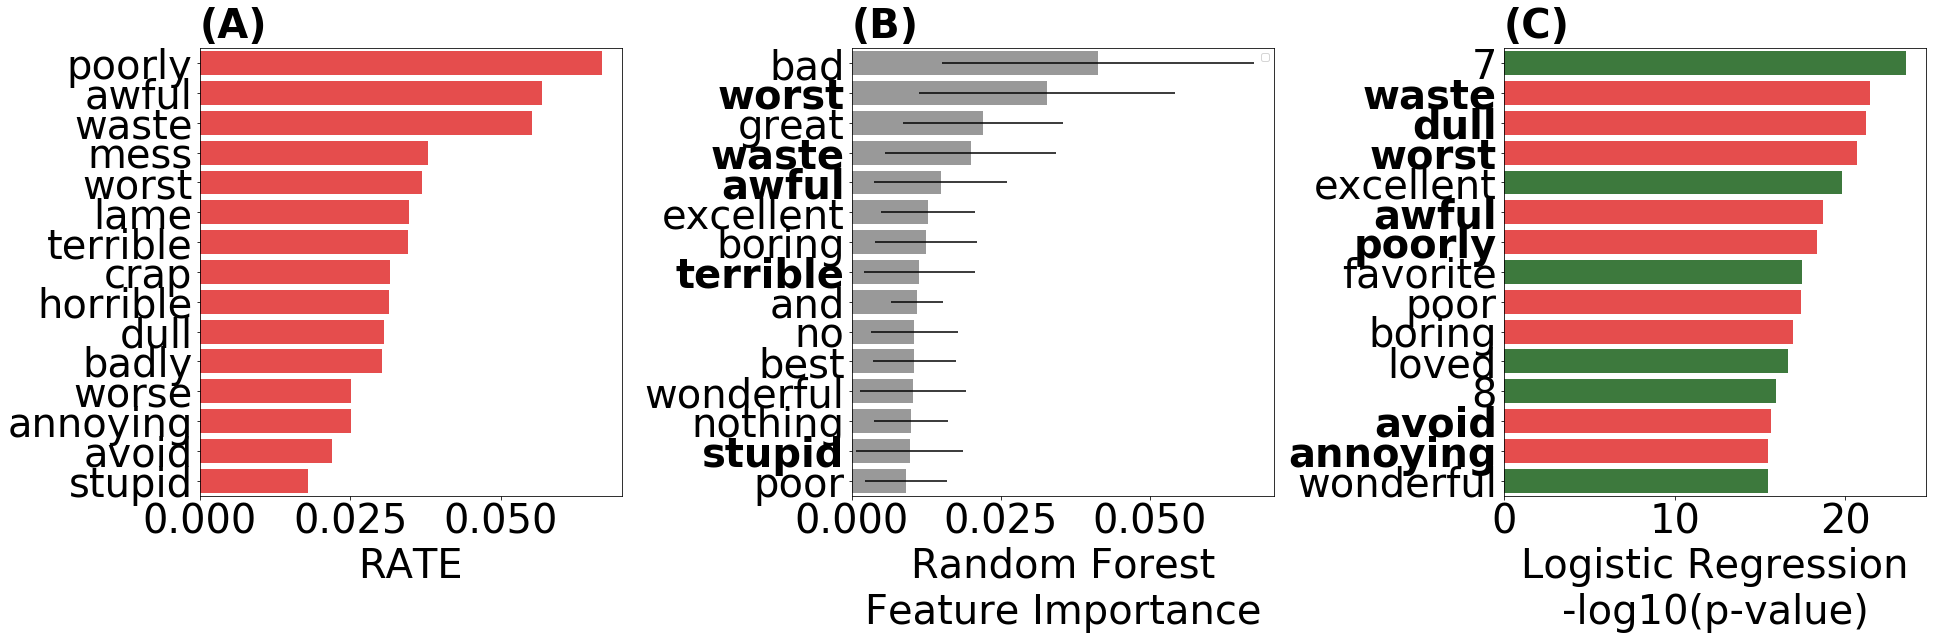

In [17]:
# RATE + logistic regression plot
n_plot_rows = 15
plotsize = 9
plottitlesize = 40
axislabelsize = 40
axisticksize = 40
legendfontsize = 40

# Bar colours - [negative, positive, no effect]
bar_colours = ["darkgreen", "red", "Gray"]
baralpha = 0.8

fig, axes = plt.subplots(1, 3, figsize=(3*plotsize, 1*plotsize))

df = pd.DataFrame({"RATE" : rate,
                    "RF_imp" : rf.feature_importances_,
                    "RF_imp_sd" : np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0),
                    "LR_pvalue" : -np.log10(lr_fit_result.pvalues[1:]),
                    "LR_coef" : lr_fit_result.params[1:],
                    "Word_idx" : np.arange(rate.shape[0])})

df["Word"] = [id_to_word[id+INDEX_FROM+1] for id in df["Word_idx"]]

# Effect directions
df["ESA_sign"] = ["Positive effect" if pos else "Negative effect" for pos in M_B[0,:] > 0.0]
df["LR_sign"] = ["Positive effect" if val > 0.0 else "Negative effect" for val in df["LR_coef"]]
# RATE
df = df.sort_values(by=["RATE"], ascending=False)

if df.iloc[0]["ESA_sign"]=="Positive effect":
    colours = bar_colours[:2]
else:
    colours = bar_colours[:2][::-1]

sns.barplot(y="Word", x="RATE", hue="ESA_sign", data=df.head(n_plot_rows),
            palette=colours, alpha=baralpha,
            dodge=False, orient="h", ax=axes[0])

# Random forest
df = df.sort_values(by=["RF_imp"], ascending=False)
sns.barplot(y="Word", x="RF_imp", data=df.head(n_plot_rows),
            color=bar_colours[2], dodge=False, orient="h",
            ax=axes[1], alpha=baralpha, xerr=df.head(n_plot_rows)["RF_imp_sd"].values)
axes[1].set_ylabel("")

# Logistic regression
df['sort_lr'] = df["LR_coef"].abs()
df = df.sort_values(by=["LR_pvalue"], ascending=False)

if df.iloc[0]["LR_sign"]=="Positive effect":
    colours = bar_colours[:2]
else:
    colours = bar_colours[:2][::-1]

sns.barplot(y="Word", x="LR_pvalue", hue="LR_sign", data=df.head(n_plot_rows),
            palette=colours, alpha=baralpha,
            dodge=False, orient="h", ax=axes[2])

for ax in axes:
    ax.tick_params("both", labelsize=axisticksize)
    ax.yaxis.label.set_size(axislabelsize)
    ax.xaxis.label.set_size(axislabelsize)

axes[0].get_legend().remove()
axes[2].get_legend().remove()

for i, t in enumerate(["(A)", "(B)", "(C)"]):
    axes[i].set_title(t, fontsize=plottitlesize, loc="left", weight="bold", y=1.01)

for i, t in enumerate(["RATE", "Random Forest\nFeature Importance", "Logistic Regression\n-log10(p-value)"]):
    axes[i].set_xlabel(t, fontsize=axislabelsize)
    
# Common words in bold
rate_words = [lab.get_text() for lab in axes[0].get_yticklabels()]

for ax in axes[1:3]:
    words = [lab.get_text() for lab in ax.get_yticklabels()]
    # [x+1 if x >= 45 else x+5 for x in l]
    word_weight = ["bold" if w in rate_words else "normal" for w in words]
    for i, lab in enumerate(ax.get_yticklabels()):
        lab.set_weight(word_weight[i])

for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()

In [ ]:
# Count common words
N = np.sum(rate>1.0/p) # Number of included words

df["RATE_rank"] = df["RATE"].rank(ascending=False)
df["LR_rank"] = df["LR_pvalue"].rank(ascending=False)
df["RF_rank"] = df["RF_imp"].rank(ascending=False)
df = df.sort_values(by=["RATE"], ascending=False)

rf_common_words = df.head(N)["Word"].values[df.head(N)["RF_rank"].values < N+1]
lr_common_words = df.head(N)["Word"].values[df.head(N)["LR_rank"].values < N+1]

print "Common words with RATE in top {} words:".format(N)
print "Random forest: {}".format(rf_common_words.shape[0])
print "Logistic regression: {}".format(lr_common_words.shape[0])